In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Import dependencies, data and modeling components.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from matplotlib import pyplot as plt


In [3]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [4]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss of both
from tensorflow.keras.losses import BinaryCrossentropy

In [5]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback, BackupAndRestore

In [6]:
# Use the tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteDH48ML/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteDH48ML/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


# 2. Visualize data and build dataset.

In [7]:
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

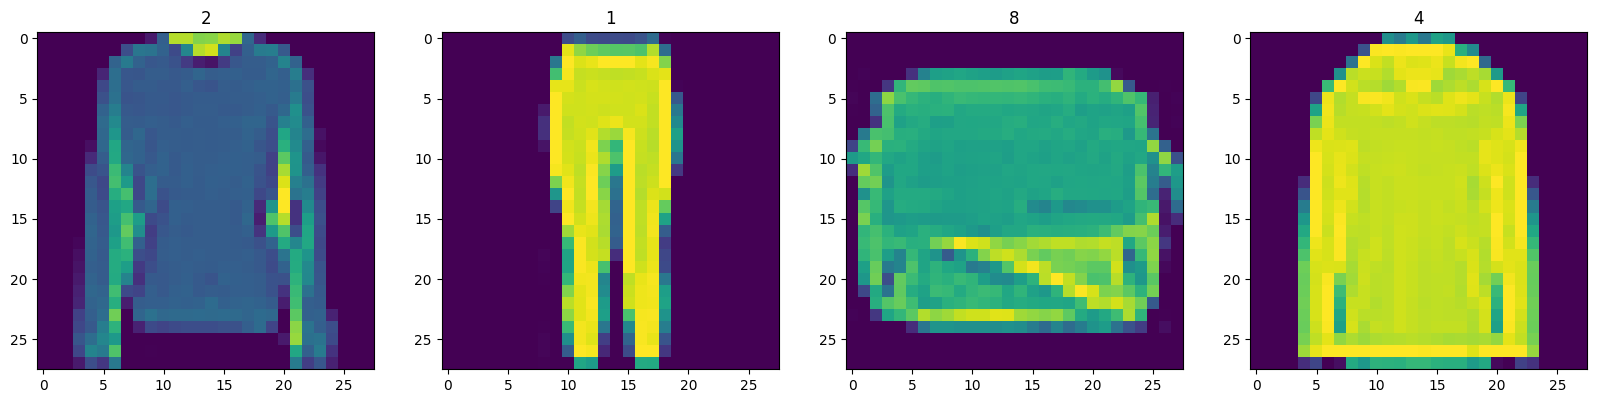

In [8]:
# Setup the subplot formatting
fig, ax = plt.subplots(ncols = 4, figsize=(20, 20))

# Loop 4 times and get images
for idx in range(4):
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific axis
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image laebel as the plot title
    ax[idx].title.set_text(sample['label'])

In [9]:
# Scale and return images only
def scale_images(data):
    image = data['image']

    return image / 255

In [10]:
# Reload the dataset
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images proprocessing step
ds = ds.map(scale_images)
# Cache the dataset for that batch
ds = ds.cache()
# Shuffle it up
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduce the likelihood of bottlenecking
ds = ds.prefetch(64)

# 3. Build neural network.

## 3.1 Build generator.

In [11]:
def build_generator():
    model = Sequential()

    # Take in random values and reshape it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128,5,padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128,5,padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv block 1
    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv block 2
    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

In [12]:
generator = build_generator()

In [13]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [14]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 7s 7s/step


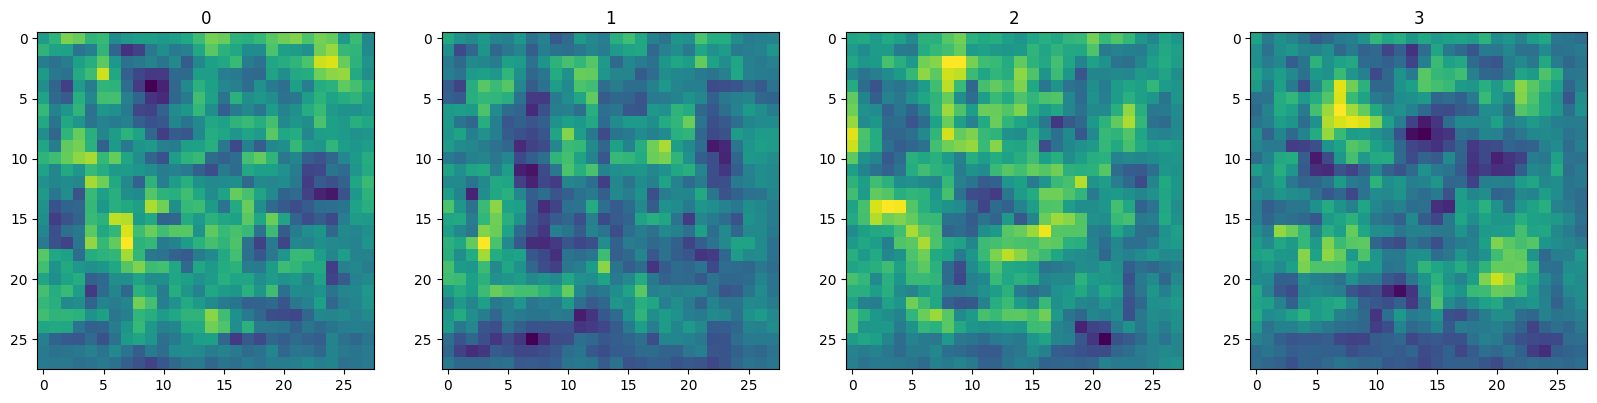

In [15]:
# Generate new fashion
fig, ax = plt.subplots(ncols = 4, figsize=(20, 20))

# Loop 4 times and get images
for idx,img in enumerate(img):
    # Grab an image and label
    # Plot the image using a specific axis
    ax[idx].imshow(np.squeeze(img))
    # Appending the image laebel as the plot title
    ax[idx].title.set_text(idx)

## 3.2 Build dicriminator.

In [16]:
def build_discriminator():
    model = Sequential()

    #Conv block 1
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #Conv block 2
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #Conv block 3
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #Conv block 4
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [17]:
discriminator = build_discriminator()

In [18]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [19]:
discriminator.predict(np.expand_dims(img, 0))

1/1 [==============================] - 0s 159ms/step


array([[0.50501084]], dtype=float32)

# 4. Construct training loop.

## 4.1 Setup optimizers and losses.

In [20]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

## 4.2 Build subclassed model.

In [21]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the disc model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some nonise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss
            total_g_loss =self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss": total_d_loss, "g_loss":total_g_loss}

In [22]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [23]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

## 4.3 Build callback

In [24]:
backup = tf.keras.callbacks.BackupAndRestore(backup_dir='/content/drive/MyDrive/ColabNotebooks/GANv2/tmp/backup')
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        img_path = '/content/drive/MyDrive/ColabNotebooks/GANv2/images'
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join(img_path, f'generated_img_{epoch+1}_{i}.png'))

In [25]:
# Load generator and discriminator weights
## generator.load_weights('/content/drive/MyDrive/ColabNotebooks/GANv2/generator.h5')
## discriminator.load_weights('/content/drive/MyDrive/ColabNotebooks/GANv2/discriminator.h5')

## 4.3 Train

Epoch 1/2000
469/469 [==============================] - 27s 30ms/step - d_loss: 0.5104 - g_loss: 2.5083
Epoch 2/2000
469/469 [==============================] - 13s 27ms/step - d_loss: 0.3123 - g_loss: 5.5867
Epoch 3/2000
469/469 [==============================] - 13s 27ms/step - d_loss: 0.3880 - g_loss: 1.4686
Epoch 4/2000
469/469 [==============================] - 13s 28ms/step - d_loss: 0.2763 - g_loss: 2.6348
Epoch 5/2000
469/469 [==============================] - 13s 27ms/step - d_loss: 0.5995 - g_loss: 1.1562
Epoch 6/2000
469/469 [==============================] - 13s 27ms/step - d_loss: 0.6366 - g_loss: 0.5069
Epoch 7/2000
469/469 [==============================] - 13s 27ms/step - d_loss: 0.4713 - g_loss: 0.1231
Epoch 8/2000
469/469 [==============================] - 13s 28ms/step - d_loss: 0.5920 - g_loss: 0.2622
Epoch 9/2000
469/469 [==============================] - 13s 27ms/step - d_loss: 0.5304 - g_loss: 0.4473
Epoch 10/2000
469/469 [==============================] - 13s 27m

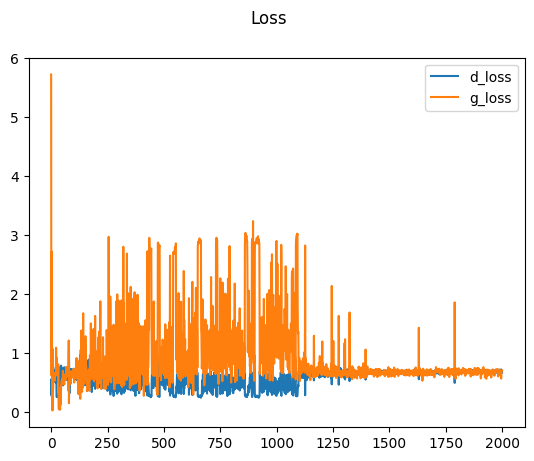

In [26]:
# Run ephochs.
hist = fashgan.fit(ds, epochs=2000, callbacks=[ModelMonitor(), backup])
## 4.4 Review performance
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 183ms/step


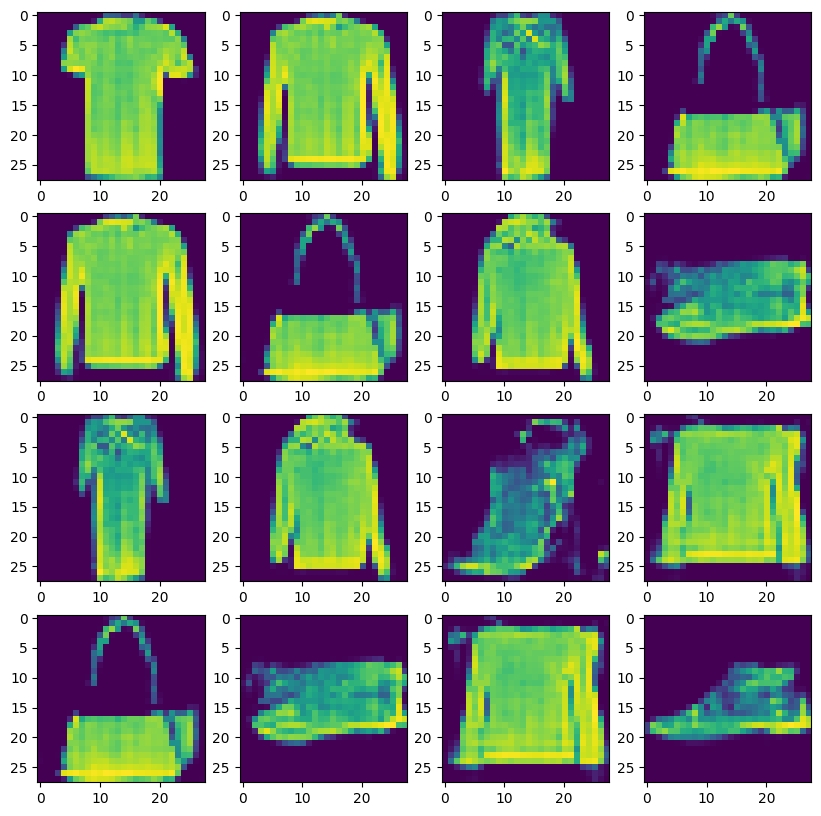

In [27]:
# 5. Test out the generator.
## 5.1 Generate images.
imgs = generator.predict(tf.random.normal((16, 128, 1)))
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
  for c in range(4):
    ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

In [ ]:
## 5.2 Save the model.
generator.save('/content/drive/MyDrive/ColabNotebooks/GANv2/generator.h5')
discriminator.save('/content/drive/MyDrive/ColabNotebooks/GANv2/discriminator.h5')